In [21]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
from P02_MSIE.T01_prototype_class.DE_IM_VRPTW_classV5_2 import VRPTW, SOL_UPPER_BOUND

In [22]:
class AIMH_ENV(gym.Env):
    def __init__(self, vrp):
        super().__init__()
        self.action_space = spaces.Box(
            low = np.array([0, 0, 0], dtype=np.float32), 
            high= np.array([5, 5, 1], dtype=np.float32), 
            shape=(3,),
            dtype=np.float32,
        )
            # order = [
        #     "best_solution",
        #     "F",
        #     "CR",
        #     "MG",
        #     "percent_convergence",
        #     "std_pop",
        #     "total_iteration",
        # ]
        self.observation_space = gym.spaces.Box(
            low=np.array([0, 0, 0, 0, 0, 0, 0], dtype=np.float32),
            high=np.array([SOL_UPPER_BOUND, 10, 10, 1, 1, 1, 1e5], dtype=np.float32),
            shape=(7,),  # 7 features
            dtype=np.float64,
        )
        self.vrp = vrp
        pass


    def _get_obs(self):
        
        state = self.vrp.get_current_state()
        obs = np.array(
            [
                np.float32(state["best_solution"]),
                np.float32(state["F"]),
                np.float32(state["CR"]),
                np.float32(state["MG"]),
                np.float32(state["percent_convergence"]),
                np.float32(state["std_pop"]),
                np.float32(state["total_iteration"]),
            ]
        )
        
        return obs
    
    def _get_info(self):
        """Compute auxiliary information for debugging.

        Returns:
            dict: Info in addition to the observation
        """
        return self.vrp.get_info()
    

    def reset(self, seed=None, options=None):
        # np.random.seed(seed or 42)
        self.vrp.reset()
        super().reset(seed=seed)
        observation = self._get_obs()
        info = self._get_info()
        return observation, info

    def step(self, action):
        self.vrp.action(action)
        self.vrp.evolve()
        reward = self.vrp.get_reward()
        if self.vrp.is_terminated():
            terminated = True
            truncated = True
        else:
            terminated = False
            truncated = False
        observation = self._get_obs()
        info = self._get_info()
        return observation, reward, terminated, truncated, info

    

In [23]:
AIMH_ENV(vrp=None).action_space.sample()

array([0.4019993, 2.4107108, 0.8623183], dtype=float32)

In [24]:
distance = (
    pd.read_excel(
        r"../../Source/rl_meta_test_data.xlsx", sheet_name="distance"
    )
    .fillna(9999999)
    .to_numpy()
)

df_vehicle = (
    pd.read_excel(
        r"../../Source/rl_meta_test_data.xlsx", sheet_name="vehicle"
    )
    .iloc[:, :2]
    .to_numpy(dtype=int)
)
vehicle = df_vehicle[0]

df_101 = pd.read_excel(
    r"../../Source/rl_meta_test_data.xlsx", sheet_name="customer"
).iloc[:, 3:]
demand = df_101.iloc[:, 0].to_numpy()
readyTime = df_101.iloc[:, 1].to_numpy()
dueDate = df_101.iloc[:, 2].to_numpy()
serviceTime = df_101.iloc[:, -1].to_numpy()

kwargs = {
    "distance": distance,
    "demand": demand,
    "readyTime": readyTime,
    "dueDate": dueDate,
    "serviceTime": serviceTime,
    "vehicle": vehicle,
}

dimensions = len(distance) - 1 + vehicle[0]
interval_it = 20
patience = 200
population_size = 4
bounds = np.array([[0, 1]] * dimensions)
F_rate = 0.5
CR_rate = 0.5
MG_rate = 0.5

vrptw = VRPTW(
    population_size=population_size,
    dimensions=dimensions,
    bounds=bounds,
    distance=distance,
    demand=demand,
    readyTime=readyTime,
    dueDate=dueDate,
    serviceTime=serviceTime,
    vehicle=vehicle,
    interval_it=interval_it,
    patience=patience,
)

In [25]:
obs, info = AIMH_ENV(vrp=vrptw).reset()
print(obs)

[1.00000e+06 5.00005e-01 5.00005e-01 5.00000e-01 0.00000e+00 0.00000e+00
 0.00000e+00]


In [26]:
# TODO: Fix the environment to pass the checks
# UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
#   logger.warn(f"{pre} is not within the observation space.")
# Environment has issues: Deterministic step observations are not equivalent for the same seed and action


from gymnasium.utils.env_checker import check_env

env = AIMH_ENV(vrp=vrptw)

# This will catch many common issues
try:
    check_env(env)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

Environment passes all checks!


c:\Users\admin\Coding\research\rl-meta-test\.venv\Lib\site-packages\gymnasium\utils\env_checker.py:333: UserWarning: WARN: For Box action spaces, we recommend using a symmetric and normalized space (range=[-1, 1] or [0, 1]). See https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html for more information.
  logger.warn(
c:\Users\admin\Coding\research\rl-meta-test\.venv\Lib\site-packages\gymnasium\utils\passive_env_checker.py:134: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float64, actual type: float32
  logger.warn(
c:\Users\admin\Coding\research\rl-meta-test\.venv\Lib\site-packages\gymnasium\utils\passive_env_checker.py:134: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float64, actual type: float32
  logger.warn(
c:\Users\admin\Coding\research\rl-meta-test\.venv\Lib\site-packages\gymnasium\utils\passive_env_checker.py:158: UserWarning: WARN: The obs returned by the 

In [27]:
from stable_baselines3 import SAC

model = SAC("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 18.8      |
|    ep_rew_mean     | -1.04e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 155       |
|    time_elapsed    | 0         |
|    total_timesteps | 75        |
----------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.6     |
|    ep_rew_mean     | -988     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 104      |
|    time_elapsed    | 1        |
|    total_timesteps | 141      |
| train/             |          |
|    actor_loss      | 187      |
|    critic_loss     | 2.92e+05 |
|    ent_coef        | 1.01     |
|    ent_coef_loss   | -0.134   |
|    learning_rate   | 0.0003   |
|    n_updates       | 40       |
------------

In [37]:
import pandas as pd

obs, info = env.reset()
terminated = False
truncated = False

data_array = []
while not (terminated or truncated):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    data_added = {**info, "reward": reward, "action": action}
    data_array.append(data_added)

df = pd.DataFrame.from_dict(data_array)
display(df)

,F,CR,MG,best_solution,percent_convergence,std_pop,total_iteration,idx_iteration,patience_remaining,reward,action
0,1,0.000010,1.000000,65.009194,0.000000,3.187443,20,19,181,-65.009194,"[5.0, 0.0, 1.0]"
1,1,0.422135,0.327295,58.833553,0.000000,0.967663,40,39,182,-58.833553,"[4.411398, 0.422135, 0.32729542]"
2,1,0.765427,0.541640,58.606917,0.000000,1.060486,60,59,196,-58.606917,"[3.593598, 0.7654275, 0.54164034]"
3,1,0.610304,0.701316,54.854754,0.000000,2.233133,80,79,190,-54.854754,"[2.6876712, 0.6103042, 0.70131564]"
4,1,1.000000,0.694208,54.854754,0.000000,1.348270,100,99,170,-54.854754,"[3.00114, 3.2854602, 0.69420785]"
5,1,1.000000,0.694928,54.854754,64.460647,1.348270,120,119,150,-54.854754,"[3.6644068, 4.570259, 0.6949277]"
6,1,1.000000,0.839525,54.854754,58.285006,1.061075,140,139,130,-54.854754,"[3.3780117, 4.0587835, 0.83952534]"
7,1,1.000000,0.446052,54.854754,58.058369,0.603814,160,159,110,-54.854754,"[2.519841, 3.1090426, 0.44605178]"
8,1,1.000000,0.089012,54.854754,54.306207,0.603814,180,179,90,-54.854754,"[2.2029517, 1.9538631, 0.089012265]"
9,1,1.000000,0.046380,54.854754,54.306207,0.603814,200,199,70,-54.854754,"[3.7369325, 1.6329032, 0.046380013]"


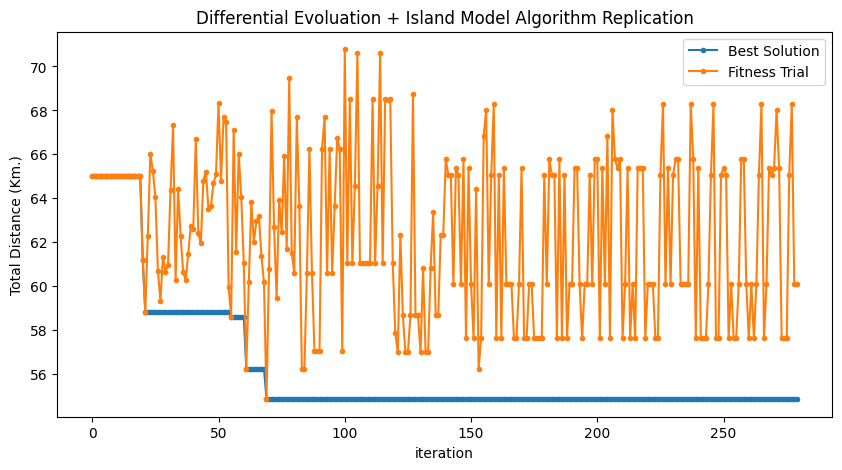

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(10, 5))
x = np.arange(vrptw.idx_iteration + 1)
y1 = vrptw.global_solution_history
y2 = vrptw.fitness_trial_history
ax.plot(x, y1, marker=".", label="Best Solution")
ax.plot(x, y2, marker=".", label="Fitness Trial")
ax.set(
    xlabel="iteration",
    ylabel="Total Distance (Km.)",
    title="Differential Evoluation + Island Model Algorithm Replication",
)
ax.legend()
plt.show()
